In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

In [74]:
# all in nanoseconds
df = pd.concat([pd.read_csv(i) for i in glob.glob('results_*.csv')])

In [75]:
df = df.rename(columns=lambda x: x.strip())

In [76]:
df.set_index('Cells', inplace=True)


In [79]:
df.sort_index(inplace=True)

In [80]:
df['Preprocessed Speedup'] = df.Classic / df.Preprocessed

df['General GPU Speedup'] = df.Classic / df['GPU General']
df['Reordered Memory General GPU Speedup'] = df.Classic / df['GPU reordered memory general']

df['Unrolled GPU Speedup'] = df.Classic / df['GPU JIT']
df['Reordered Memory General Unrolled GPU Speedup'] = df.Classic / df['GPU reordered memory JIT']

In [81]:
speedup_cols = ['Preprocessed Speedup','General GPU Speedup', 'Reordered Memory General GPU Speedup','Unrolled GPU Speedup','Reordered Memory General Unrolled GPU Speedup']

In [82]:
colors = ['#377eb8', '#ff7f00', '#4daf4a',
              '#f781bf', '#a65628', '#984ea3',
              '#999999', '#e41a1c', '#dede00']

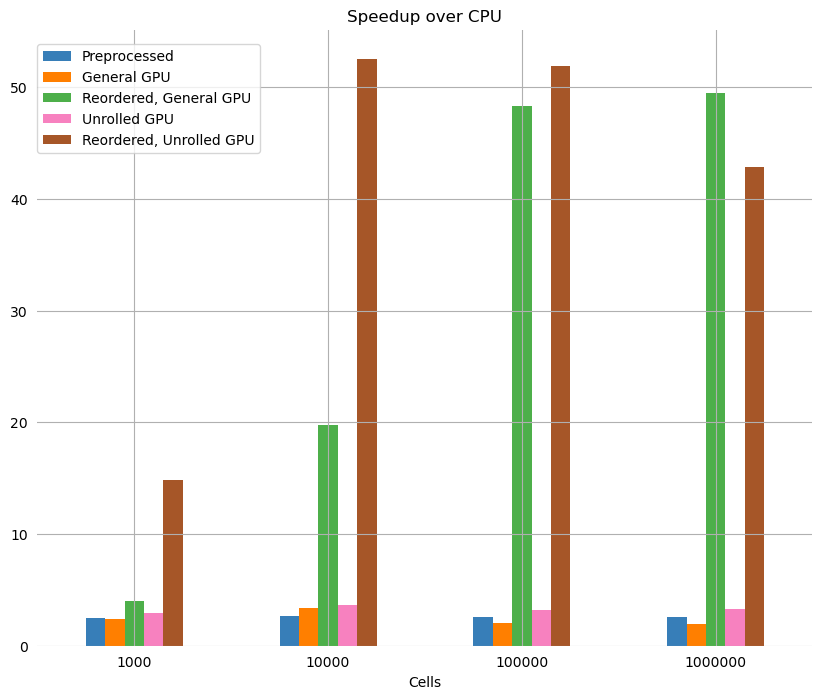

In [90]:
fig, ax = plt.subplots(figsize=(10,8))

df[speedup_cols].plot.bar(ax=ax, color = colors, legend=False)

ax.spines[:].set_visible(False)
ax.grid()
ax.tick_params(width=0, which='both')
ax.tick_params(rotation=0, axis='x')
ax.set_title('Speedup over CPU')

ax.set_

ax.legend(
    ['Preprocessed', 'General GPU', 'Reordered, General GPU', 'Unrolled GPU', 'Reordered, Unrolled GPU']
, loc = (0.0, 0.8))

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

df[speedup_cols].plot.scatter(ax=ax, color = colors, legend=False)

ax.spines[:].set_visible(False)
ax.grid()
ax.tick_params(width=0, which='both')
ax.set_title('Speedup over CPU')

fig.legend(loc = (0.5, 0.2));